In [1]:
from utils.helpers import setup_slurm_env
setup_slurm_env()

# Imports #
import numpy as np
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoModelForSeq2SeqLM, AutoTokenizer, T5Tokenizer
import torch
import os
import pandas as pd
from datasets import load_dataset
import torch.nn.functional as F
from tqdm import tqdm

# Project imports #
import sys


import utils
from mind2web.dataloader import build_split_datasets
from utils import CACHE_DIR
from utils import log_response
# sys.path.append('./Mind2Web/src')

In [23]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", cache_dir=CACHE_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=CACHE_DIR, device_map="auto")
model.eval();

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/accelerate/utils/modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['decoder.embed_tokens', 'encoder.embed_tokens']
  warnings.warn(


In [3]:
# utils.reload('mind2web.dataloader')

idx_split_map = {0:"test_task", 1:"test_domain", 2:"test_website"}
split_idx_map = {v:k for k,v in idx_split_map.items()}

cal_dict, test_dict = build_split_datasets(idx_split_map.values(),
                                            tokenizer,
                                              seed=42,
                                              frac=0.1,
                                              cache_dir=CACHE_DIR)


Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

In [4]:
# utils.reload('utils')
choices_to_token_ids = cal_dict['test_domain'].choices_token_ids_mapping()
choices_idx = torch.tensor(list(choices_to_token_ids.values()), device=device)
max_new_tokens = 15 #1?

def run_evaluation(data_sets:dict, max_iter=None):
    outputs = []

    for ds_split, ds in data_sets.items():
        split_idx = split_idx_map[ds_split]
        relative_idx = 0
        for i, item in enumerate(tqdm(ds, desc="Generating...")):
            if max_iter is not None and i > max_iter:
                break
            model_input = utils.llm.tensorize_item(item, device)
 
            with torch.inference_mode():
                    out = model.generate(
                        **model_input,
                        eos_token_id=model.config.eos_token_id,
                        max_new_tokens=max_new_tokens,
                        return_dict_in_generate=True,
                        output_scores=True
                    )
     
            decoded = tokenizer.decode(out["sequences"][0], skip_special_tokens=True)
            pred_label, pred_action, pred_value = utils.llm.parse_output(decoded)
            labels_tokens = item.get("labels")
            
            # Calculate choice probabilities
            logits = out["scores"][0]
            probs = F.softmax(logits, dim=-1)[:, choices_idx][0]
            choices_probs = dict(zip(choices_to_token_ids.keys(), probs.cpu().tolist()))
            labels = item.get("labels").strip()
            outputs.append(
                    [
                        relative_idx,
                        ds.data[relative_idx]["annotation_id"],
                        ds.data[relative_idx]["action_uid"],
                        pred_label, pred_action, pred_value,
                        labels.split('.')[0],
                        labels, 
                        choices_probs,
                        choices_probs.get(pred_label, 0),
                        split_idx,
                        labels_tokens

                    ]    
                )
            log_response(ds.data[relative_idx]["annotation_id"], ds.data[relative_idx]["action_uid"], decoded)
            relative_idx += 1

            del out # Tighten memory

    cols = ["relative_idx", "annotation_id", "action_uid", "pred_label", "pred_action", "pred_value",
             "label",'label_text', "choices_probs", "prob", "test_split", "labels_tokens"]
    results_df = pd.DataFrame(outputs, columns=cols)

    return results_df
#temp = run_evaluation({'test_task': cal_dict[idx_split_map[0]]}, max_iter=32)

# 2-3.46 seconds per sample on GPU

In [4]:
# cal_df = run_evaluation(cal_dict, max_iter=None)
# if len(cal_df):
    # cal_df.to_pickle("cal_results.pkl")
cal_df = pd.read_pickle("cal_results_02.pkl")
cal_df.head()

,index,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens
0,0,0572899e-7c07-4a2f-a77b-bba4f432a7ad,7194e8bf-6cf3-4f36-a37f-70fd065c4aac,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.00027643711655400693, 'B': 0.999675869...",0.999676,0,B.\nAction: CLICK\n
1,1,0572899e-7c07-4a2f-a77b-bba4f432a7ad,aa34483b-ad90-4054-b38b-d29157a1c517,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.002066487679257989, 'B': 0.99775898456...",0.997759,0,B.\nAction: CLICK\n
2,2,0572899e-7c07-4a2f-a77b-bba4f432a7ad,49b0e49e-deab-4400-987a-4cfd6ba09a84,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.000798287452198565, 'B': 0.99910348653...",0.999103,0,B.\nAction: CLICK\n
3,3,0572899e-7c07-4a2f-a77b-bba4f432a7ad,aa40812d-f178-4d28-b6de-6ec9ca1b2758,B,TYPE,SFTBAO,B,B.\nAction: TYPE\nValue: SFTBAO,"{'A': 0.0004186475707683712, 'B': 0.9995331764...",0.999533,0,B.\nAction: TYPE\nValue: SFTBAO
4,4,0572899e-7c07-4a2f-a77b-bba4f432a7ad,998b187b-44a3-4f3d-93de-e00fdd23e4cf,B,TYPE,Joe,B,B.\nAction: TYPE\nValue: Joe,"{'A': 0.0013455424923449755, 'B': 0.9985216259...",0.998522,0,B.\nAction: TYPE\nValue: Joe


In [5]:

def get_threshold(scores, alpha: float):
    N = len(scores)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(scores.values)
    threshold = sorted_scores[k - 1]
    return threshold


cal_df['correct'] = cal_df['pred_label'] == cal_df['label']
# probability of the true label
cal_df['true_prob'] = cal_df.apply(lambda row: row['choices_probs'][row['label']] if row['label'] in row['choices_probs'] else 0, axis=1)
grouped = cal_df.groupby('annotation_id')
score_per_group = 1 - grouped['true_prob'].min()

threshold = get_threshold(score_per_group, alpha=0.1)
print('Procedure threshold', threshold)
naive_threshold = get_threshold(1 - cal_df['true_prob'], alpha=0.2)
print('Naive threshold:', naive_threshold)


Procedure threshold 0.9998231713107089
Naive threshold: 0.9146593138575554


In [20]:
# Model is probably biased towards A when not certain
cal_df[cal_df['correct'] == False]['pred_label'].value_counts()

pred_label
A    287
D      6
F      4
E      2
B      2
C      1
Name: count, dtype: int64

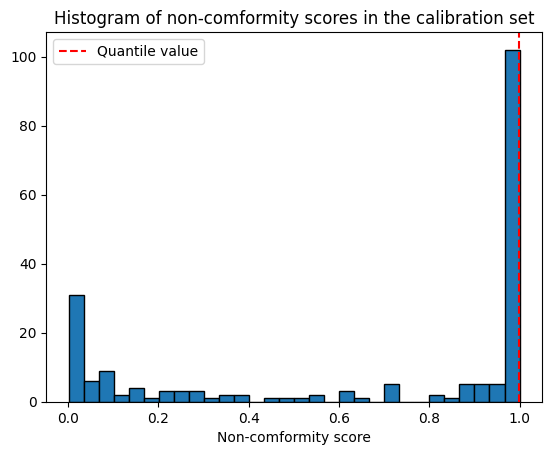


A good predictor should have low non-comformity scores, concentrated at the left side of the figure


In [ ]:
# plot histogram of non-comformity scores in the calibration set 
import matplotlib.pyplot as plt
plt.hist(score_per_group, bins=30, edgecolor='k', linewidth=1)
plt.axvline(
    x=threshold, linestyle='--', color='r', label='Quantile value'
)
plt.title(
    'Histogram of non-comformity scores in the calibration set'
)
plt.xlabel('Non-comformity score')
plt.legend()
plt.show()
print('A good predictor should have low non-comformity scores, concentrated at the left side of the figure')

Evaluation on Cal Set
Avg task accuracy: 0.7458
Avg annotation accuracy: 0.3433


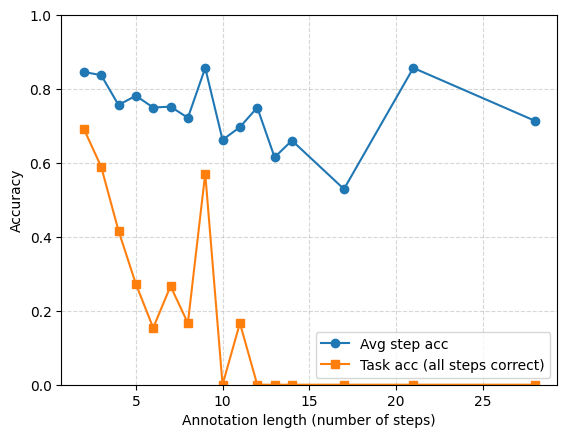

In [23]:
print("Evaluation on Cal Set")
print(f"Avg task accuracy: {cal_df['correct'].mean():.4f}")
print(f"Avg annotation accuracy: {grouped['correct'].min().mean():.4f}")
utils.plot.accuracy_vs_length(cal_df);

In [6]:
# test_df = run_evaluation(test_dict, max_iter=20)
# if len(test_df):
#     test_df.to_pickle("test_results.pkl")
test_df = pd.read_pickle("test_results.pkl")
test_df.head()


,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens
0,0,91695df8-f256-47c9-8c37-06e8d0fc758f,73e0e7ed-d784-4b7a-a06c-48324e44ce7b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.15193545818328857, 'B': 0.846724271774...",0.846724,0,B.\nAction: CLICK\n
1,1,91695df8-f256-47c9-8c37-06e8d0fc758f,ea2865e4-2858-478c-bf83-93d576cad774,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0009128428064286709, 'B': 0.9990413784...",0.999041,0,B.\nAction: CLICK\n
2,2,91695df8-f256-47c9-8c37-06e8d0fc758f,c70a5d9b-8777-4ff7-a17d-1f76012e14ba,B,TYPE,08817,B,B.\nAction: TYPE\nValue: 08817,"{'A': 0.002360111102461815, 'B': 0.99749302864...",0.997493,0,B.\nAction: TYPE\nValue: 08817
3,3,91695df8-f256-47c9-8c37-06e8d0fc758f,3e671043-cab2-4e44-a1ce-3ed9de91d16b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0015765962889418006, 'B': 0.9983214735...",0.998321,0,B.\nAction: CLICK\n
4,4,91695df8-f256-47c9-8c37-06e8d0fc758f,60888ab2-b605-4886-8dac-6ba72b6cde0a,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.010480514727532864, 'B': 0.98891687393...",0.988917,0,B.\nAction: CLICK\n


In [8]:
import numpy as np
import pandas as pd

def _token_f1(pred: str, label: str) -> float:
    p = set(pred.strip().split())
    l = set(label.strip().split())
    if not p and not l:
        return 1.0
    if not p or not l:
        return 0.0
    tp = len(p & l)
    fp = len(p - l)
    fn = len(l - p)
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec = tp / (tp + fn) if (tp + fn) else 0.0
    return 0.0 if (prec == 0 or rec == 0) else 2 * prec * rec / (prec + rec)

def evaluate_results_df(results_df: pd.DataFrame) -> dict:
    # Element accuracy: mean of the “correct” flag (generated == label)
    element_acc = results_df["correct"].mean()

    # Operation F1: token-level F1 between generated and label_text
    op_f1 = np.mean([
        _token_f1(str(g), str(l))
        for g, l in zip(results_df["pred_label"], results_df["label_text"])
    ])

    # Step SR (macro across tasks): average of mean correctness per annotation_id
    per_ann_correct = results_df.groupby("annotation_id")["correct"].mean()
    step_sr = per_ann_correct.mean()

    # Task SR (all steps correct within an annotation_id)
    task_sr = (results_df.groupby("annotation_id")["correct"].all()).mean()

    return {
        "element_acc": round(element_acc,2),
        "op_f1": round(op_f1,2),
        "step_sr": round(step_sr,2),
        "task_sr": round(task_sr,2),
    }

print("Evaluation on Cal Set")
print("Overall Metrics:")
print(evaluate_results_df(cal_df))

for idx_split, split_name in idx_split_map.items():
    print(f"Metrics for split: {split_name}")
    split_df = cal_df[cal_df["test_split"] == idx_split]
    print(evaluate_results_df(split_df))


Evaluation on Cal Set
Overall Metrics:
{'element_acc': np.float64(0.75), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.77), 'task_sr': np.float64(0.34)}
Metrics for split: test_task
{'element_acc': np.float64(0.87), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.87), 'task_sr': np.float64(0.46)}
Metrics for split: test_domain
{'element_acc': np.float64(0.71), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.75), 'task_sr': np.float64(0.33)}
Metrics for split: test_website
{'element_acc': np.float64(0.73), 'op_f1': np.float64(0.0), 'step_sr': np.float64(0.75), 'task_sr': np.float64(0.25)}


In [7]:
# test_df = run_evaluation(test_dict.values(), max_iter=10)
# test_df.to_pickle("test_results.pkl")
# test_df = pd.read_pickle("test_results.pkl")

test_df['correct'] = test_df['pred_label'] == test_df['label']
test_df['pred_set'] = test_df['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])
test_df['pred_set_size'] = test_df['pred_set'].apply(len)
test_task_group = test_df.groupby('annotation_id')
test_df.head()

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,labels_tokens,correct,pred_set,pred_set_size
0,0,91695df8-f256-47c9-8c37-06e8d0fc758f,73e0e7ed-d784-4b7a-a06c-48324e44ce7b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.15193545818328857, 'B': 0.846724271774...",0.846724,0,B.\nAction: CLICK\n,True,"[A, B, C, E, F]",5
1,1,91695df8-f256-47c9-8c37-06e8d0fc758f,ea2865e4-2858-478c-bf83-93d576cad774,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0009128428064286709, 'B': 0.9990413784...",0.999041,0,B.\nAction: CLICK\n,True,"[A, B]",2
2,2,91695df8-f256-47c9-8c37-06e8d0fc758f,c70a5d9b-8777-4ff7-a17d-1f76012e14ba,B,TYPE,08817,B,B.\nAction: TYPE\nValue: 08817,"{'A': 0.002360111102461815, 'B': 0.99749302864...",0.997493,0,B.\nAction: TYPE\nValue: 08817,True,"[A, B]",2
3,3,91695df8-f256-47c9-8c37-06e8d0fc758f,3e671043-cab2-4e44-a1ce-3ed9de91d16b,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.0015765962889418006, 'B': 0.9983214735...",0.998321,0,B.\nAction: CLICK\n,True,"[A, B]",2
4,4,91695df8-f256-47c9-8c37-06e8d0fc758f,60888ab2-b605-4886-8dac-6ba72b6cde0a,B,CLICK,None,B,B.\nAction: CLICK,"{'A': 0.010480514727532864, 'B': 0.98891687393...",0.988917,0,B.\nAction: CLICK\n,True,"[A, B, C]",3


Evaluation on Test Set
Avg task accuracy: 0.7143
Avg annotation accuracy: 0.1250


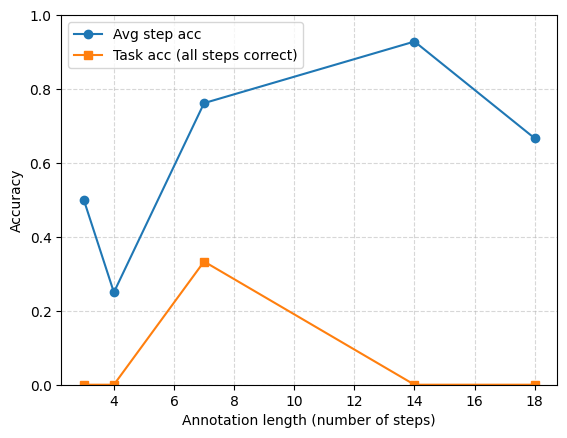

In [9]:
print("Evaluation on Test Set")
print(f"Avg task accuracy: {test_df['correct'].mean():.4f}")
print(f"Avg annotation accuracy: {test_task_group['correct'].min().mean():.4f}")
utils.plot.accuracy_vs_length(test_df);


In [ ]:
# cal_df['pred_set'] = cal_df['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])
# cal_df[cal_df['correct'] == False].apply(lambda row: row['label'] in row['pred_set'], axis=1).mean()

np.float64(0.7218543046357616)

In [8]:
example = test_df[test_df['correct'] == False].iloc[0]
example

relative_idx                                                    12
annotation_id                 91695df8-f256-47c9-8c37-06e8d0fc758f
action_uid                    f425232b-adc6-4047-b3ac-d56d8909b7df
pred_label                                                       A
pred_action                                                   None
pred_value                                                    None
label                                                            B
label_text                              B.\nAction: TYPE\nValue: 2
choices_probs    {'A': 0.9986311793327332, 'B': 0.0005027084262...
prob                                                      0.998631
test_split                                                       0
labels_tokens                           B.\nAction: TYPE\nValue: 2
correct                                                      False
pred_set                                              [A, B, D, F]
pred_set_size                                                 

In [32]:
test_task = test_dict['test_task']
html_context, seq_in, seq_out, prev_actions, choices_str = test_task.prompt_view[12]
# print(f"CONTEXT:\n{seq_context}")
# print(f"INPUT:\n{seq_in}")
print(html_context)
print(seq_in)
# print(seq_out)

# print(prev_actions)
# print(choices_str)
test_task.data[12].keys()
task = test_task.data[12]['confirmed_task']
screenshot = test_task.data[12]['screenshot']
print(task)

<html> <div> <div> <a choose your add-ons /> <input id=0 text 0 /> <a choose your add-ons /> </div> <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li> <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a> </li> <a commercial account> Commercial Account </a> </ul> </div> </html>
Based on the HTML webpage above, try to complete the following task:
Task: Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.
Previous actions:
[button]  Reservations -> HOVER
[link]  Budget Truck -> CLICK
[textbox]  US City,State or Zip Code -> TYPE: 08817
[textbox]  mm/dd/yyyy -> CLICK
[link]  12 -> CLICK
[select]  Select Pick-up Time -> SELECT: 02:30 PM
[input]   -> CLICK
[button]  Find Your Truck -> CLICK
[button]  Select Truck -> CLICK
[input]   -> TYPE: 100
[button]  Continue to Location  ->

In [46]:

prompt = f"""
{html_context}
Click the input field labeled "0" under the "Furniture Pad" add-on section to set the quantity to two dozen
the correct action is very likely one of the following. Analyze them carefully:

A. None of the above
B. <input id=0 text 0 />
C. <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li>
D. <li id=2> <a id=3 reservations> Reservations </a> </li>
E. <a id=3 reservations> Reservations </a>
F. <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a>
"""

model_input = tokenizer(prompt, return_tensors="pt",max_length=512).to(device)
with torch.inference_mode():
        out = model.generate(
        **model_input,
        max_new_tokens=15,
        return_dict_in_generate=True,
        output_scores=False
                    )
     
decoded = tokenizer.decode(out["sequences"][0], skip_special_tokens=True)
print(decoded)

B. Action: TYPE Value: 2


In [38]:
print(prompt)


<html> <div> <div> <a choose your add-ons /> <input id=0 text 0 /> <a choose your add-ons /> </div> <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li> <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a> </li> <a commercial account> Commercial Account </a> </ul> </div> </html>
Based on the HTML webpage above, try to complete the following task:
Task: Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.
Previous actions:
[button]  Reservations -> HOVER
[link]  Budget Truck -> CLICK
[textbox]  US City,State or Zip Code -> TYPE: 08817
[textbox]  mm/dd/yyyy -> CLICK
[link]  12 -> CLICK
[select]  Select Pick-up Time -> SELECT: 02:30 PM
[input]   -> CLICK
[button]  Find Your Truck -> CLICK
[button]  Select Truck -> CLICK
[input]   -> TYPE: 100
[button]  Continue to Location  -

In [19]:
import gc
from string import Template
from transformers import AutoModelForVision2Seq #AutoModelForImageTextToText
from utils.prompts import oracle_prompt_template
try:
    # Not enough memory for 2 models so we need to free GPU memory
    for d in set(model.hf_device_map.values()):
        if isinstance(d, int):
            torch.cuda.set_device(d)
            torch.cuda.empty_cache()
    del model
    gc.collect()         
    torch.cuda.empty_cache()       
    torch.cuda.ipc_collect()
except NameError:
    pass

#################
import re
from pathlib import Path
from typing import List, Dict, Any

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM  # Qwen-VL uses the causal LM head

class Oracle:
    def __init__(
        self,
        model_name: str = "Qwen/Qwen3-VL-8B-Instruct",
        cache_dir: str = None,
        device: str = None,
        dtype=torch.float16,
    ):
        self.processor = AutoProcessor.from_pretrained(model_name, cache_dir=cache_dir)
        self.model = AutoModelForVision2Seq.from_pretrained(
            model_name,
            cache_dir=cache_dir,
            dtype=dtype,
            device_map="auto" if device is None else None,
        )
        if device is not None:
            self.model.to(device)
        self.device = device or self.model.device

    def _build_prompt(self,
                      task:str,
                      prev_actions:str,
                      html_context: str,
                      choices:str,
                      candidates: str,
                      ) -> str:
        prompt_template = Template(oracle_prompt_template)
        prompt = prompt_template.safe_substitute(
            task=task,
            previous_actions=prev_actions,
            html=html_context,
            options=choices,
            prediction_set_options=candidates,
        )
        return prompt

    def ask(self,
            task:str,
            prev_actions:str,
            html_context: str,
            choices:str,
            candidates: str,
            image: Image.Image) -> str:
        """
        Returns the chosen candidate id (or empty string if None selected).
        """
   
        prompt = self._build_prompt(task, prev_actions, html_context, choices, candidates)
        image =  image.convert("RGB")

        messages = [{
            "role": "user",
            "content": [
                {"type": "image"},  # placeholder; processor will insert the image tokens
                {"type": "text", "text": prompt},
            ],
        }]
        text = self.processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = self.processor(images=[image.convert("RGB")], text=[text], return_tensors="pt").to(self.device)

        with torch.inference_mode():
            output_ids = self.model.generate(
                **inputs,
                max_new_tokens=32,
                do_sample=False,
            )
            

        text = self.processor.decode(output_ids[0], skip_special_tokens=True)
        return text.strip()
        # # Extract first letter A-F
        # m = re.search(r"\b([A-F])\b", text, re.IGNORECASE)
        # if not m:
        #     return ""
        # letter = m.group(1).upper()
        # if letter == "A":  # None of the above
        #     return ""
        # idx = ord(letter) - ord("B")
        # if 0 <= idx < len(candidates):
        #     return candidates[idx]["id"]
        # return ""

oracle = Oracle(cache_dir=CACHE_DIR)
oracle.ask(task=task,
            prev_actions=prev_actions,
            html_context=html_context,
            choices=choices_str,
            candidates=example['pred_set'],
            image=screenshot)


/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

'user\n\n### ROLE\nYou are a helpful human annotator assisting a web navigation agent. The agent is confused and has narrowed down the next step to a few likely options, but it cannot distinguish which one is correct.\n### USER TASK\nRent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.\nPrevious Actions: \n[button]  Reservations -> HOVER\n[link]  Budget Truck -> CLICK\n[textbox]  US City,State or Zip Code -> TYPE: 08817\n[textbox]  mm/dd/yyyy -> CLICK\n[link]  12 -> CLICK\n[select]  Select Pick-up Time -> SELECT: 02:30 PM\n[input]   -> CLICK\n[button]  Find Your Truck -> CLICK\n[button]  Select Truck -> CLICK\n[input]   -> TYPE: 100\n[button]  Continue to Location  -> CLICK\n[button]  Select Pick-up Location -> CLICK\n\n\n### HTML CONTEXT\n<html> <div> <div> <a choose your add-ons /> <input id=0 text 0 /

In [20]:
print(_)

user

### ROLE
You are a helpful human annotator assisting a web navigation agent. The agent is confused and has narrowed down the next step to a few likely options, but it cannot distinguish which one is correct.
### USER TASK
Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.
Previous Actions: 
[button]  Reservations -> HOVER
[link]  Budget Truck -> CLICK
[textbox]  US City,State or Zip Code -> TYPE: 08817
[textbox]  mm/dd/yyyy -> CLICK
[link]  12 -> CLICK
[select]  Select Pick-up Time -> SELECT: 02:30 PM
[input]   -> CLICK
[button]  Find Your Truck -> CLICK
[button]  Select Truck -> CLICK
[input]   -> TYPE: 100
[button]  Continue to Location  -> CLICK
[button]  Select Pick-up Location -> CLICK


### HTML CONTEXT
<html> <div> <div> <a choose your add-ons /> <input id=0 text 0 /> <a choose your add-on

In [ ]:
"""
user

### ROLE
You are a helpful human annotator assisting a web navigation agent. The agent is confused and has narrowed down the next step to a few likely options, but it cannot distinguish which one is correct.
### USER TASK
Rent a truck with the lowest rent with two dozen furniture pads for 100 miles at zip 08817 on April 12 at 2:30 pm rented truck is to be returned to the exact location and date, and the pickup and drop off will be at the nearest location.
Previous Actions: 
[button]  Reservations -> HOVER
[link]  Budget Truck -> CLICK
[textbox]  US City,State or Zip Code -> TYPE: 08817
[textbox]  mm/dd/yyyy -> CLICK
[link]  12 -> CLICK
[select]  Select Pick-up Time -> SELECT: 02:30 PM
[input]   -> CLICK
[button]  Find Your Truck -> CLICK
[button]  Select Truck -> CLICK
[input]   -> TYPE: 100
[button]  Continue to Location  -> CLICK
[button]  Select Pick-up Location -> CLICK


### HTML CONTEXT
<html> <div> <div> <a choose your add-ons /> <input id=0 text 0 /> <a choose your add-ons /> </div> <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li> <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a> </li> <a commercial account> Commercial Account </a> </ul> </div> </html>

### AVAILABLE OPTIONS
The smaller model has provided the following possible actions:
A. None of the above
B. <input id=0 text 0 />
C. <ul id=1> <li id=2> <a id=3 reservations> Reservations </a> </li>
D. <li id=2> <a id=3 reservations> Reservations </a> </li>
E. <a id=3 reservations> Reservations </a>
F. <li id=4> <a commercial rental add-ons> Commercial Rental Add-ons </a>


### THE AMBIGUOUS OPTIONS (Prediction Set)
The correct action is very likely one of the following. Analyze them carefully:
['A', 'B', 'D', 'F']

### INSTRUCTIONS
1. Analyze the User Task and the HTML Context (and the screenshot if available).
2. Identify the single correct element from the Prediction Set options above.
3. Formulate a natural language instruction to guide the agent to that specific element.
4. **Crucial:** Your instruction must be "Discriminative". Mention specific text labels, icons, or the location of the element to help the agent separate it from the other options.

### RESPONSE FORMAT
Provide your response as a direct command to the agent. 
- If the action is clicking, describe exactly what to click.
- If the action is typing, specify exactly what to type and where.

Example 1 (Click): "Click the 'Menu' button found in the top-left navigation bar."
Example 2 (Type): "Type 'The Matrix' into the search bar located in the header."
Example 3 (Select): "Select 'Price: Low to High' from the dropdown menu."

Your Response:  

assistant
Click the input field labeled "0" under the "Furniture Pad" add-on section to set the quantity to two dozen.
"""

In [22]:
del oracle
gc.collect()         
torch.cuda.empty_cache()       
torch.cuda.ipc_collect()

CODE TO HANDLE:

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

from mind2web.dataloader import MultiChoiceDataset, get_data_split
from mind2web.evaluate import FastActionEvaluatorMultiChoice  # note the file name
# if installed as a package, you can also do: from mind2web.evauate import FastActionEvaluatorMultiChoice

# Load tokenizer/model
# model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")

# Prepare data (adjust paths/splits as needed)
# data_dir = "osunlp/Multimodal-Mind2Web"
# split_file = "test_task"  # example split
# data = get_data_split(data_dir, split_file)
# dataset = MultiChoiceDataset(data, tokenizer, num_candidates=5, max_context_len=512, mode="multichoice")

# Run evaluation
evaluator = FastActionEvaluatorMultiChoice(tokenizer, max_context_len=512)
result = evaluator.evaluate_dataset(
    test_dict["test_task"],  # dataset to evaluate
    model,
    batch_size=8,
    top_k=50,
    output_path='./results',  # set a folder path to save JSON outputs
    name="test_task",
    template=None,     # optionally a tuple (prefix_context, suffix_input)
    max_new_tokens=50,
)

print(result)


/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (125915272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import sys
import importlib

sys.path.append('./Mind2Web/src') 

# Force reload the metric module
if 'action_prediction.metric' in sys.modules:
    importlib.reload(sys.modules['action_prediction.metric'])

from action_prediction.metric import ActionEvaluatorGeneration, ActionEvaluatorMultiChoice

evaluator = ActionEvaluatorMultiChoice(tokenizer)
test_dataset = dataset
test_key = "task"
output_path = os.getcwd()
result = evaluator.evaluate_dataset(
    test_dataset,
    model,
    output_path=output_path,
    name=test_key,
    template=None, #lm_template,
    top_k=50#cfg.top_k,)
)


 12%|█▏        | 158/1339 [48:58<6:06:01, 18.60s/it, action_f1=0, element_acc=0]



KeyboardInterrupt: 

In [ ]:
# df = pd.DataFrame(test_task_ds)
# len(df.groupby("annotation_id"))
# subsample[0]['action_reprs']

# test_domain_ds = ds['test_domain']
# test_task_ds = ds['test_task']
# test_website_ds = ds['test_website']
count = 0
missing_count = 0
mulit = {}
missing = {}
for i, x in enumerate(test_task_ds):
    if len(x['pos_candidates']) > 1:
        count += 1
        mulit[i] = x['annotation_id']
    if len(x['pos_candidates']) == 0:
        # print('Missing pos_candidates:', x['annotation_id'])
        missing_count += 1
        missing[i] = x['annotation_id']

print("Number of samples with multiple positive candidates in test_website:", count)
print("Number of samples with missing positive candidates in test_website:", missing_count)

In [116]:
df[df['annotation_id'].str.startswith("15486e7c")]

,action_uid,raw_html,cleaned_html,operation,pos_candidates,neg_candidates,website,domain,subdomain,annotation_id,confirmed_task,screenshot,action_reprs,target_action_index,target_action_reprs,action_id


In [82]:
from bs4 import BeautifulSoup
html = task_df.iloc[0]["cleaned_html"]
soup = BeautifulSoup(html, "html.parser")

def get_element_html(node_id: str):
    el = soup.find(attrs={"backend_node_id": node_id})
    return str(el) if el is not None else None

# Example: show HTML for the top-1 candidate
best_id = task_df.iloc[0]["pos_candidates"][0]
print(get_element_html(best_id))

None


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Download the MindAct Candidate Generation model
print("Downloading MindAct Candidate Generation model...")
model_name = "osunlp/MindAct_CandidateGeneration_deberta-v3-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=CACHE_DIR)

# Load model
candidate_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    cache_dir=CACHE_DIR,
    torch_dtype=torch.float16,  # Use float16 for efficiency
    device_map="auto"  # Automatically handle device placement
)

print(f"Model {model_name} downloaded and loaded successfully!")
print(f"Model type: {type(candidate_model)}")
print(f"Number of parameters: {sum(p.numel() for p in candidate_model.parameters()):,}")